In [212]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from keras.models import Sequential, clone_model, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, MaxPooling1D, Flatten, Conv1D, Reshape
from sklearn.model_selection import train_test_split
import copy
import json
import requests

In [213]:
start_date = '2016-10-01'
start_date = pd.to_datetime(start_date).date()
end_date = dt.date.today()
df = yf.download("AAPL", start=start_date, end=end_date, auto_adjust=True)
vix = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=True)
df.columns = [i.lower() for i in df.columns]
df = df.join(vix['Close'], how='inner')
df = df.rename(columns={'Close': 'vix'})

df.index = pd.to_datetime(df.index)
df = df.resample('D').interpolate()

#load historical fear and greed data from fear-greed.csv
fear_greed_historical = pd.read_csv('fear-greed.csv')
fear_greed_historical = fear_greed_historical.drop(columns=['Open', 'High', 'Low'])
fear_greed_historical['Date'] = pd.to_datetime(fear_greed_historical['Date'])
fear_greed_historical['Date'] = fear_greed_historical['Date'].dt.date

#get latest fear and greed index data
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)
data = response.text
data = json.loads(data)
values = [(int(entry['timestamp']), float(entry['value'])) for entry in data['data']]

fear_greed = pd.DataFrame(values, columns=['timestamp', 'fear_greed_index'])
fear_greed['Date'] = pd.to_datetime(fear_greed['timestamp'], unit='s')
fear_greed['Date'] = fear_greed['Date'].dt.date
fear_greed = fear_greed.drop(columns=['timestamp'])

#merge the fear_greed with the historical fear greed index with fear_greed having priority
fear_greed = pd.concat([fear_greed, fear_greed_historical], ignore_index=True)
fear_greed = fear_greed.drop_duplicates(subset=['Date'], keep='last')
fear_greed = fear_greed.set_index('Date')
fear_greed.index = pd.to_datetime(fear_greed.index)
fear_greed = fear_greed.sort_index()

df_end = df.index[-1]
# get rid of rows indexed by dates before the start of the stock data
fear_greed = fear_greed.loc[start_date:df_end]

#fill in the missing dates by copying values from the previous day
fear_greed = fear_greed.resample('D').interpolate()

df['fear_greed'] = fear_greed['fear_greed_index']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [214]:
df['daily_varitation'] = (df['high'] - df['low'])/df['open']
df['timestamp'] = df.index.astype(np.int64) // 10**9
df['daily_return'] = df['close'].pct_change()
#percentage return of the stock if it was bought 5 days ago
df['5day_return'] = df['close'].pct_change(periods=5)
df['15day_return'] = df['close'].pct_change(periods=15)
df['30day_return'] = df['close'].pct_change(periods=30)
df['60day_return'] = df['close'].pct_change(periods=60)
df['7day_sma'] = df['close'].rolling(window=7).mean()
df['7day_std'] = df['close'].rolling(window=7).std()
df['7day_sma+2std'] = df['7day_sma'] + 2*df['7day_std']
df['7day_sma-2std'] = df['7day_sma'] - 2*df['7day_std']
df['high_close_diff'] = df['high'] - df['close']
df['low_open_diff'] = df['low'] - df['open']
df['14day_ema'] = df['close'].ewm(span=14, adjust=False).mean()
df['macd'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
# df['stochastic_oscillator'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['atr'] = df[['high', 'low', 'close']].apply(lambda x: max(x['high'] - x['low'], abs(x['high'] - np.roll(x['close'], 1)), abs(x['low'] - np.roll(x['close'], 1))), axis=1)
df['cci'] = (df['close'] - df['close'].rolling(window=20).mean()) / (0.015 * df['close'].rolling(window=20).std())
df['williams_r'] = (df['high'].rolling(window=14).max() - df['close']) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['bollinger_bands'] = (df['close'] - df['close'].rolling(window=20).mean()) / (2 * df['close'].rolling(window=20).std())
df['price_rate_of_change'] = df['close'].pct_change(periods=9)
# df['momentum'] = df['close'] - df['close'].shift(4)
df['roc'] = (df['close'] - df['close'].shift(12)) / df['close'].shift(12)
df['obv'] = (df['volume'] * np.sign(df['close'].diff())).cumsum()
df['obv_ema'] = df['obv'].ewm(span=20, adjust=False).mean()
df['obv_roc'] = df['obv'].pct_change()
df['monday'] = df.index.weekday == 0
df['tuesday'] = df.index.weekday == 1
# df['wednesday'] = df.index.weekday == 2
# df['thursday'] = df.index.weekday == 3
# df['friday'] = df.index.weekday == 4
# df['saturday'] = df.index.weekday == 5
df['sunday'] = df.index.weekday == 6
df['month'] = df.index.month
df['quarter'] = df.index.quarter

#print rows containing nan values
import pandas as pd

#getting rid of NaN rows 
# print(df[df.isna().any(axis=1)])
df = df.dropna()

In [215]:
# you need to run this \/ (to be added to anaconda)
# pip install nltk 

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

articles = pd.read_csv('articles.csv')

articles_dict = {}
for index, row in articles.iterrows():
    date = row['date']
    if date in articles_dict:
        articles_dict[date].append(row['title'])
    else:
        articles_dict[date] = [row['title']]

sentiments = []
for index, row in df.iterrows():    
    date = index.strftime('%Y-%m-%d')
    sentiment = 0
    count = 0
    if date in articles_dict:
        for article in articles_dict[date]:
            sentiment += analyzer.polarity_scores(article)['compound']
            count += 1
    if (count > 0):
        sentiment = sentiment / count
    sentiments.append(sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\48503\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [216]:
# print non zero sentiments
non_zero_sentiments = [sentiment for sentiment in sentiments if sentiment != 0]
print(non_zero_sentiments)
print(sentiments)
# df['sentiment'] = sentiments

[0.1779, -0.3182, 0.18386666666666668, 0.12734, 0.23537999999999998, -0.11234999999999998, 0.4201, 0.06743333333333333, 0.1278, 0.1147083333333333, 0.06620000000000001, 0.08895, -0.32389999999999997, 0.10846, 0.4074, 0.09276666666666666, 0.264025, 0.3767, -0.14920000000000003, 0.43392499999999995, 0.044475, 0.5994, 0.1779, 0.14894285714285713, -0.26934, -0.05403333333333334, 0.08084, 0.28595, 0.093, 0.04845384615384617, -0.09090000000000001, -0.2023, 0.36605, 0.6078749999999999, -0.23835, 0.22555, 0.3612, 0.1806, 0.012499999999999999, 0.47569999999999996, 0.1027, -0.3412, 0.2899, 0.12050000000000001, 0.20966666666666667, -0.19466, 0.08954375, -0.33140000000000003, -0.32321999999999995, 0.075925, -0.1606, 0.21148333333333333, 0.2732, 0.7003, -0.22116250000000004, -0.10115, 0.258125, 0.0593, 0.007466666666666659, -0.23422500000000002, 0.3998, 0.24039999999999997, 0.1779, 0.3481, 0.2643666666666667, -0.1237, 0.1909, 0.2817, 0.07585, 0.03026, 0.10015714285714286, -0.06276999999999998, 0.17

Empty DataFrame
Columns: [open, high, low, volume, vix, fear_greed, daily_varitation, timestamp, daily_return, 5day_return, 15day_return, 30day_return, 60day_return, 7day_sma, 7day_std, 7day_sma+2std, 7day_sma-2std, high_close_diff, low_open_diff, 14day_ema, macd, atr, cci, williams_r, bollinger_bands, price_rate_of_change, roc, obv, obv_ema, obv_roc, monday, tuesday, sunday, month, quarter]
Index: []

[0 rows x 35 columns]


c:\programming\ml\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e+00, tolerance: 2.755e-04
  model = cd_fast.enet_coordinate_descent(


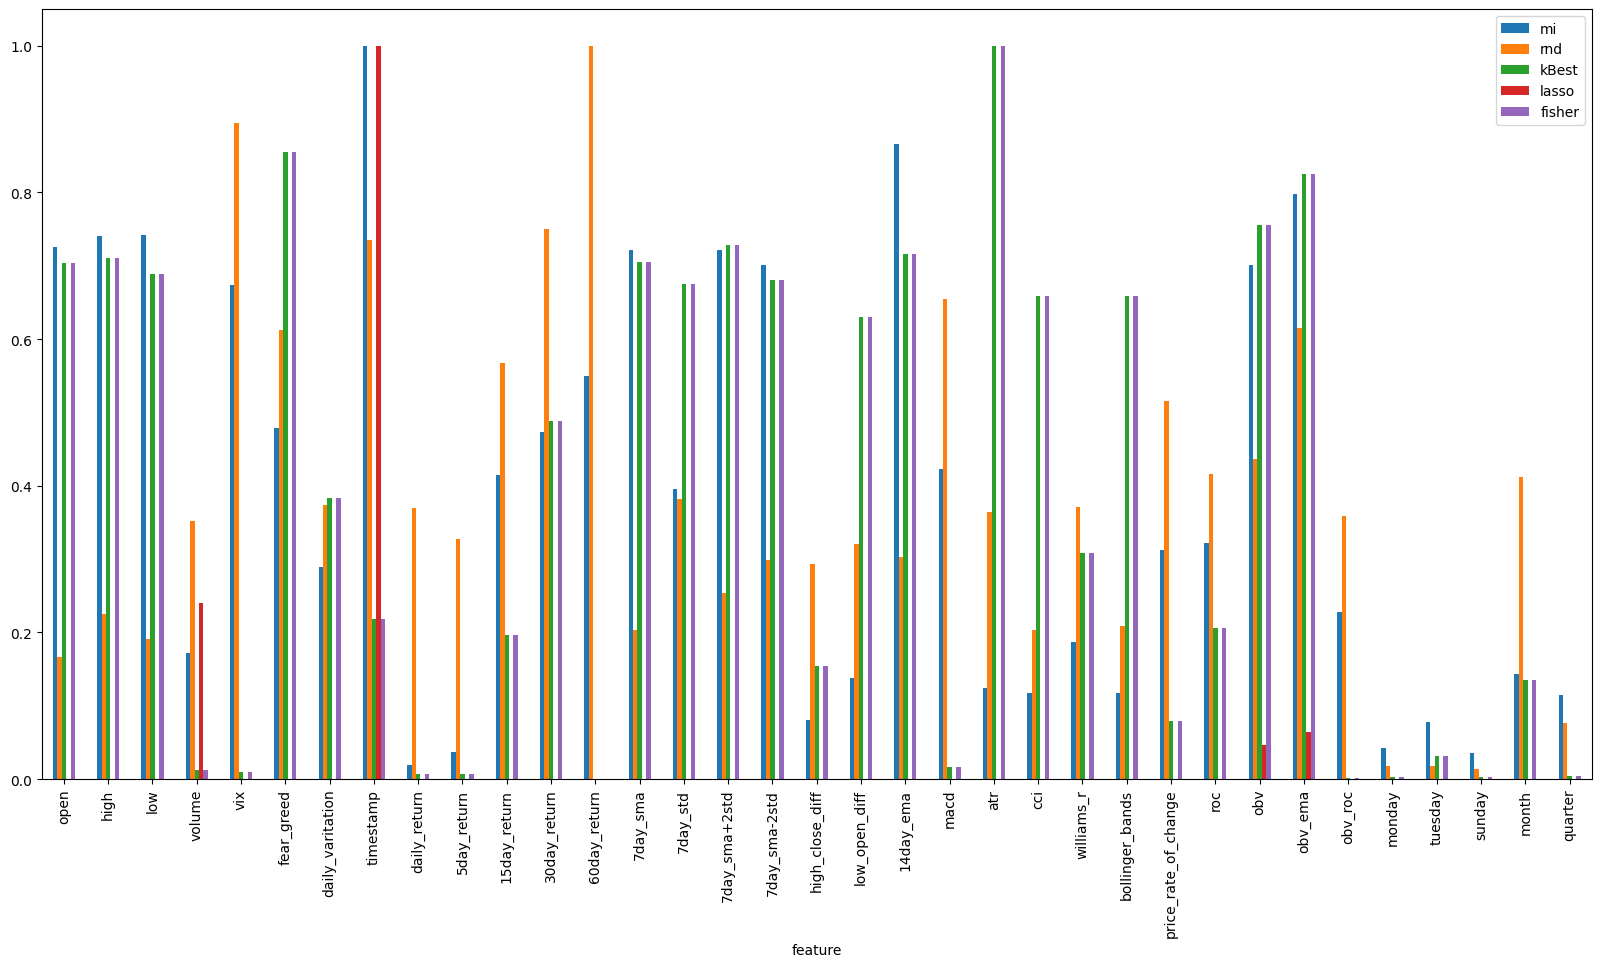

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2724 entries, 2016-12-02 to 2024-05-17
Freq: D
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  2724 non-null   float64
 1   high                  2724 non-null   float64
 2   low                   2724 non-null   float64
 3   close                 2724 non-null   float64
 4   volume                2724 non-null   float64
 5   vix                   2724 non-null   float64
 6   fear_greed            2724 non-null   float64
 7   daily_varitation      2724 non-null   float64
 8   timestamp             2724 non-null   int64  
 9   daily_return          2724 non-null   float64
 10  5day_return           2724 non-null   float64
 11  15day_return          2724 non-null   float64
 12  30day_return          2724 non-null   float64
 13  60day_return          2724 non-null   float64
 14  7day_sma              2724 non-null   float64


In [217]:

# evaluate the relevance of features using non-neural network models
return_period = 5
X = df.drop(columns=['close'])
#make y be the percentage return in 5 days
y = df['close'].pct_change(periods = -return_period)
#drop the first 5 rows of y
y = y.iloc[return_period:]
#drop the last 5 rows of y
y = y.iloc[:-return_period]
#drop the first 5 rows of x
X = X.iloc[return_period:]
#drop the last 5 rows of x
X = X.iloc[:-return_period]

#show nan rows in x 
rows_with_nan = X[X.isnull().any(axis=1)]
print(rows_with_nan)

data = pd.concat([X, y], axis=1)

#mutual information
mi = mutual_info_regression(X, y)

#kBest
test = SelectKBest(score_func=f_regression, k='all')
fit = test.fit(X, y)

#lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
coef = np.abs(lasso.coef_)

#random forest
rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)

#fishers score
fisher_score = f_regression(X, y)

results = pd.DataFrame({'feature': X.columns.values, 'mi': mi,'rnd': rnd_clf.feature_importances_, 'kBest': fit.scores_, 'lasso': coef, 'fisher': fisher_score[0]})

#scale the results to be able to compare them
results['mi'] = results['mi']/results['mi'].max()
results['rnd'] = results['rnd']/results['rnd'].max()
results['kBest'] = results['kBest']/results['kBest'].max()
results['lasso'] = results['lasso']/results['lasso'].max()
results['fisher'] = results['fisher']/results['fisher'].max()

# output the results in a graph with columns representing each method next to each other
results.plot(x='feature', y=['mi', 'rnd', 'kBest', 'lasso', 'fisher'], kind='bar', figsize=(20,10))
plt.show()

#show the amount of rows
print(df.info())

print(data)
    

In [220]:
from sklearn.metrics import mean_absolute_error

def create_enhanced_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Reshape((1, -1)))
    model.add(LSTM(50))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_features(X_train, y_train, baseline_model):
    # get indices at 50%, 60%, 70%, 80% of the dataset by splitting X_train and y_train
    indices = [int(len(X_train) * i) for i in [0.5, 0.6, 0.7, 0.8]]
    counter = -1
    feature_importances = np.zeros(X_train.shape[2])
    baseline_performance = np.zeros(len(indices))   

    for index in indices:
        counter = counter + 1
        X_train_subset = X_train[:index]
        y_train_subset = y_train[:index]
        X_val = X_train[index:index+400]
        y_val = y_train[index:index+400]

        #baseline model
        baseline_model.fit(X_train_subset, y_train_subset, epochs=300, batch_size=2197, verbose=0)
    
        # Evaluate baseline model
        baseline_performance[counter] = baseline_model.evaluate(X_val, y_val, verbose=0)

        for i in range(X_train.shape[2]):
            # Permute the values of the ith feature
            X_test_permuted = copy.deepcopy(X_val)
            np.random.shuffle(X_test_permuted[:, 0, i])
            
            # Evaluate the model with the permuted feature
            permuted_performance = baseline_model.evaluate(X_test_permuted, y_val, verbose=0)
            # print(f'Performance with permuted feature {i}: {permuted_performance}')
            
            # Calculate the importance
            importance = permuted_performance - baseline_performance[counter]
            feature_importances[i] = feature_importances[i] + importance

        if counter == len(indices) - 1:
            print("Average baseline performance: ", baseline_performance.sum() / len(indices))
            feature_importances = feature_importances / len(indices)
            feature_names = data.columns[:-1]
            feature = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
            feature = feature.sort_values(by='importance', ascending=False)
            feature.plot(x='feature', y=['importance'], kind='bar', figsize=(20,10))
            plt.show()

            # plot the actual data against the predicted data
            y_pred = baseline_model.predict(X_val)
            y_pred = y_pred.flatten()
            
            # Calculate correlation coefficient
            correlation_coefficient = np.corrcoef(y_val.flatten(), y_pred.flatten())[0, 1]
            print(f'Correlation coefficient between actual and predicted returns: {correlation_coefficient}')
            
            # Calculate residuals
            residuals = y_val.flatten() - y_pred
            
            # Plot regression line
            plt.figure(figsize=(20, 10))
            plt.scatter(y_val, y_pred)
            plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
            plt.title('Actual vs Predicted Returns')
            plt.xlabel('Actual Returns')
            plt.ylabel('Predicted Returns')
            plt.show()
            
            # Error metrics
            mae = mean_absolute_error(y_val, y_pred)
            mse = mean_squared_error(y_val, y_pred)
            rmse = np.sqrt(mse)
            print(f'Mean Absolute Error: {mae}')
            print(f'Mean Squared Error: {mse}')
            print(f'Root Mean Squared Error: {rmse}')
            
            # Confidence Intervals
            confidence_interval = 1.96 * np.std(residuals)
            print(f'95% Confidence Interval: +/- {confidence_interval}')
        


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\programming\ml\my_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


-------------------------
Enhanced LSTM model
Average baseline performance:  0.0009833127551246434


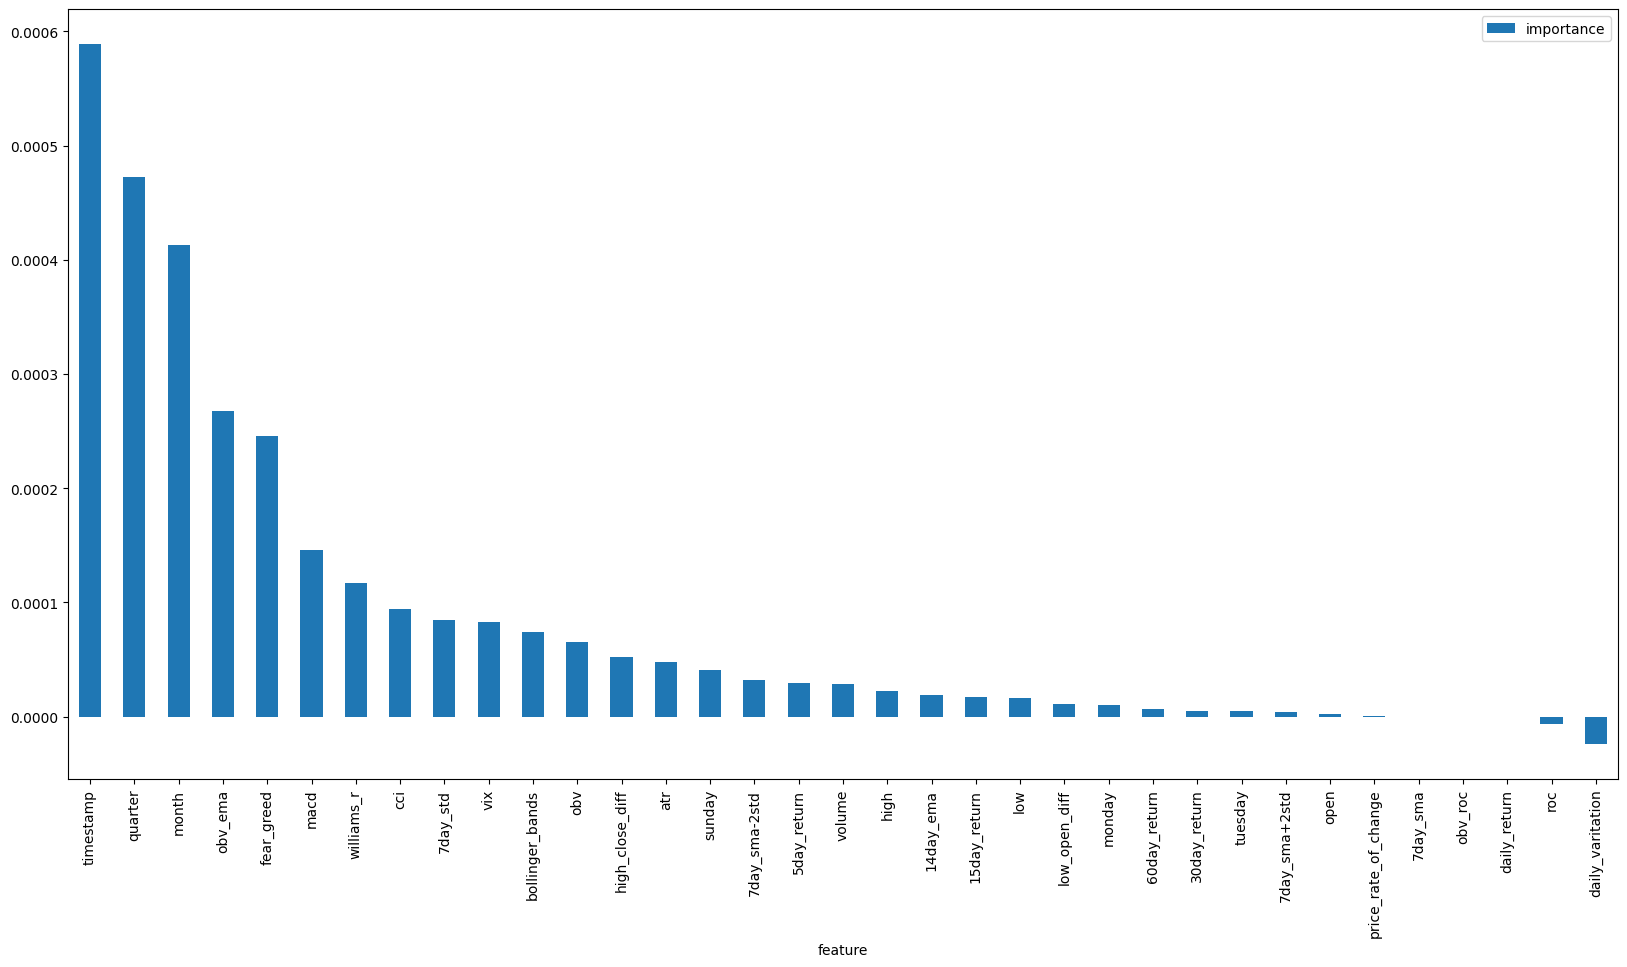

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Correlation coefficient between actual and predicted returns: 0.2686972700554741


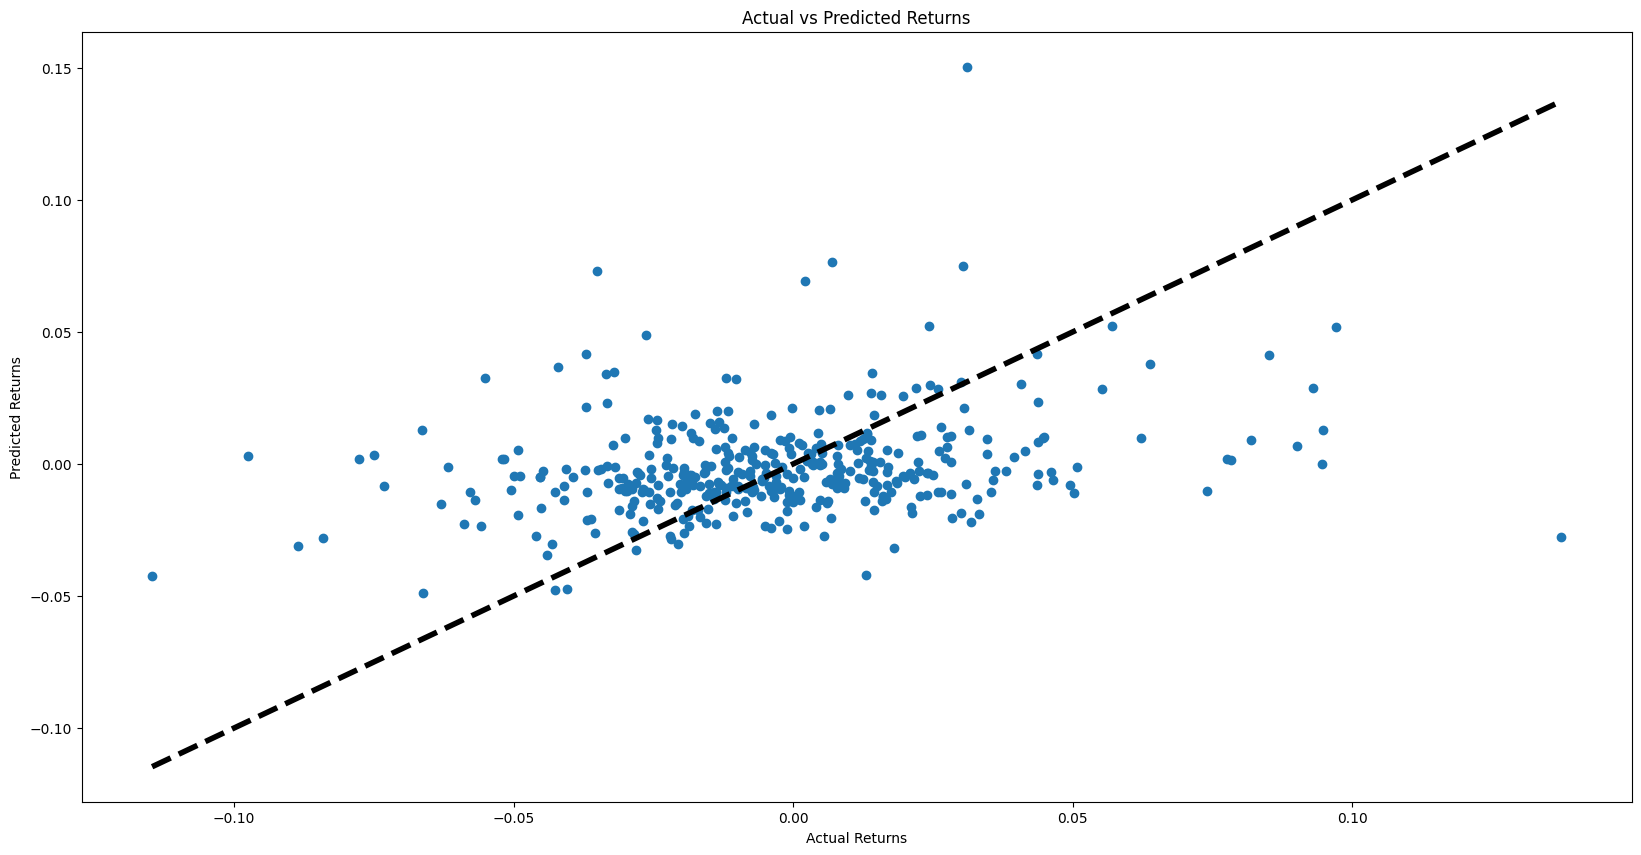

Mean Absolute Error: 0.023152107443916593
Mean Squared Error: 0.001013580233833054
Root Mean Squared Error: 0.03183677486544537
95% Confidence Interval: +/- 0.062288735650621554
-------------------------
GRU model


KeyboardInterrupt: 

In [221]:
y = data['close'].values
X = data.drop(columns=['close']).values


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

enhanced_lstm = create_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
cnn_lstm_model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))

print("-------------------------\nEnhanced LSTM model")
evaluate_features(X_train, y_train, enhanced_lstm)
print("-------------------------\nGRU model")
evaluate_features(X_train, y_train, gru_model)
print("-------------------------\nCNN LSTM model")
evaluate_features(X_train, y_train, cnn_lstm_model)
